**ACKNOWLEDGEMENTS**

I often know what I want to do but not how to code it. I've found [Copilot](https://copilot.microsoft.com/) very useful in providing helpful code examples. My KDE plot of Premium Amount is borrowed from [here](https://www.kaggle.com/code/oscarm524/ps-s4-ep12-eda-modeling-submission). I can't find the notebook where I sourced the XGBoost params used in my base model but thank you anyway! I have not been able to improve them using Optuna. Many thanks to the Kaggle community without which I would have learned even less than the little I know.

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 1. Import Libraries </b></div>

In [1]:
#pip install --upgrade distributed

In [1]:
import numpy as np, pandas as pd
import category_encoders as ce
import lightgbm as lgb, xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import find_peaks
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 2. Import and Examine Data </b></div>

In [2]:
train = pd.read_csv('train.csv', index_col = 'id')
test = pd.read_csv('test.csv', index_col = 'id')
submission = pd.read_csv('sample_submission.csv', index_col = 'id')

In [3]:
print(f"There are {train.shape[1]} columns and {train.shape[0]} rows in the train dataset.")
print(f"There are {test.shape[1]} columns and {test.shape[0]} rows in the test dataset.")
print(f"There are {submission.shape[0]} rows in the submission file.")

There are 20 columns and 1200000 rows in the train dataset.
There are 19 columns and 800000 rows in the test dataset.
There are 800000 rows in the submission file.


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

Data types look okay apart from Policy Start Date which should be datetime.

In [3]:
for df in [train, test]:
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    
print("Policy Start Date converted to Datetime in train and test data")

Policy Start Date converted to Datetime in train and test data


In [4]:
print("First 5 values in the dataset:")
print("")
train.head()

First 5 values in the dataset:



,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [12]:
print("Last 5 values in the dataset:")
print("")
train.tail()

Last 5 values in the dataset:



,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0
1199999,21.0,Female,NaN,Divorced,0.0,PhD,NaN,10.125323,Rural,Premium,0.0,18.0,502.0,6.0,2020-08-26 15:21:39.155231,Good,Yes,Monthly,House,2480.0


In [5]:
print("Descriptive statistics for object-type columns:")
print("")
print(train.describe(include = 'object').T)

Descriptive statistics for object-type columns:

                      count unique       top    freq
Gender              1200000      2      Male  602571
Marital Status      1181471      3    Single  395391
Education Level     1200000      4  Master's  303818
Occupation           841925      3  Employed  282750
Location            1200000      3  Suburban  401542
Policy Type         1200000      3   Premium  401846
Customer Feedback   1122176      3   Average  377905
Smoking Status      1200000      2       Yes  601873
Exercise Frequency  1200000      4    Weekly  306179
Property Type       1200000      3     House  400349


In [6]:
print("Descriptive statistics for numerical columns:")
print("")
print(train.describe(include = 'object').T)

Descriptive statistics for numerical columns:

                      count unique       top    freq
Gender              1200000      2      Male  602571
Marital Status      1181471      3    Single  395391
Education Level     1200000      4  Master's  303818
Occupation           841925      3  Employed  282750
Location            1200000      3  Suburban  401542
Policy Type         1200000      3   Premium  401846
Customer Feedback   1122176      3   Average  377905
Smoking Status      1200000      2       Yes  601873
Exercise Frequency  1200000      4    Weekly  306179
Property Type       1200000      3     House  400349


In [7]:
print("Columns with missing data:")
print("")
train.tail()
train.isnull().sum().sort_values(ascending = False).head(11)

Columns with missing data:



Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
dtype: int64

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 3. EDA</b></div>

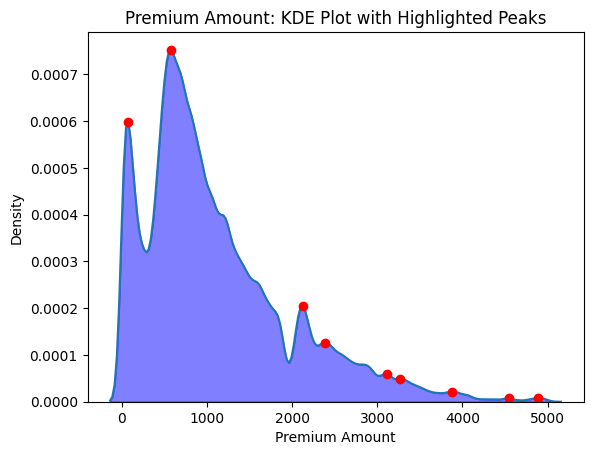

In [8]:
kde = sns.kdeplot(data = train, x = 'Premium Amount').get_lines()[0].get_data()
x = kde[0]
y = kde[1]
peaks, _ = find_peaks(y)

# Highlight the peaks
plt.plot(x[peaks], y[peaks], 'ro')  # 'ro' means red color, circle marker
plt.fill_between(x, y, color='blue', alpha = 0.5)
plt.title('Premium Amount: KDE Plot with Highlighted Peaks')
plt.show()

In [5]:
num_cols= train.select_dtypes(include='number').columns
num_cols = [val for val in num_cols]
cat_cols = train.select_dtypes(exclude='number').columns
datetime_cols = ['Policy Start Date']
cat_cols = [col for col in cat_cols if col not in datetime_cols]

print("Numerical columns:",)
print(num_cols)
print("")
print("Categorical columns excluding datetime columns:")
print(cat_cols)
print("")
print("Datetime column:")
datetime_cols

Numerical columns:
['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']

Categorical columns excluding datetime columns:
['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Datetime column:


['Policy Start Date']

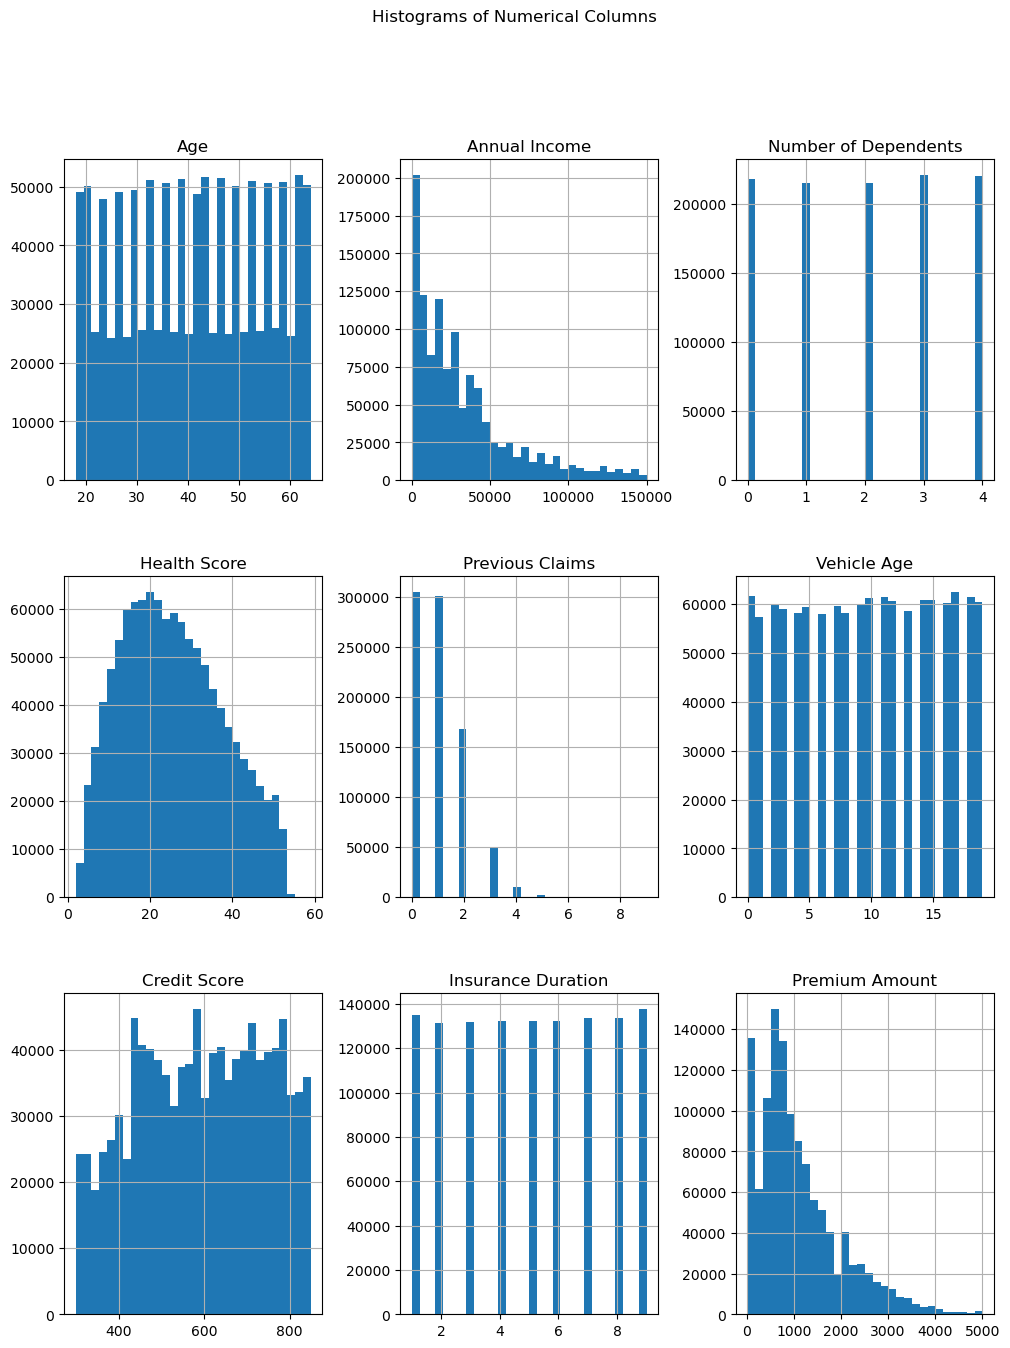

In [8]:
train[num_cols].hist(bins=30, figsize=(12, 15))
plt.suptitle('Histograms of Numerical Columns')
plt.show()

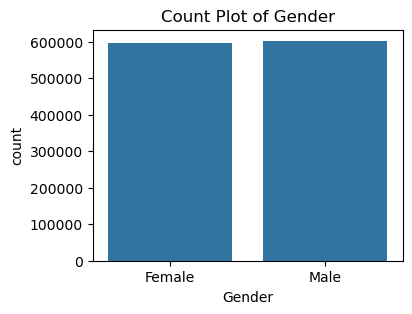

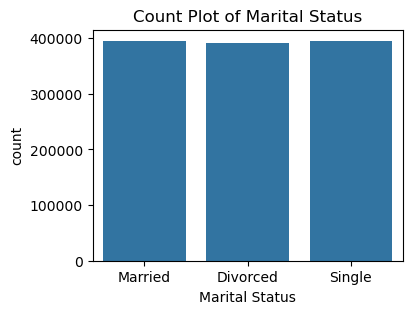

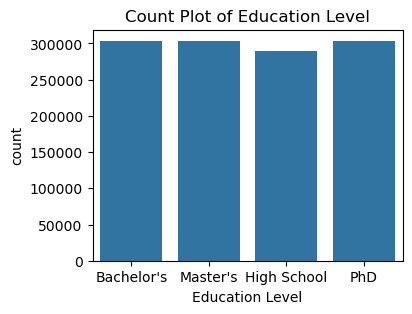

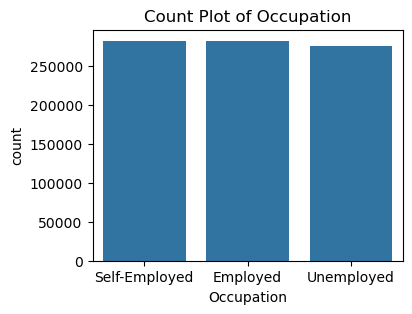

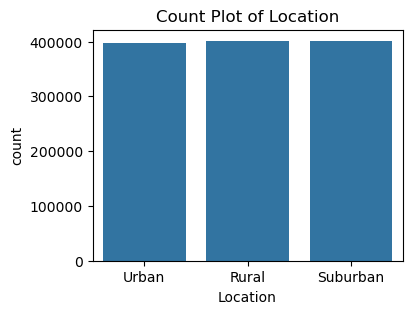

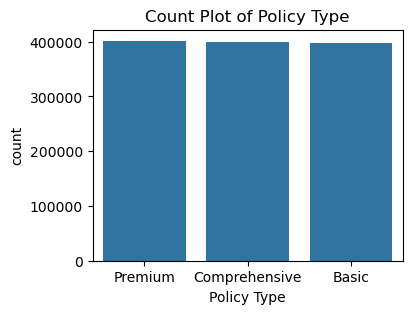

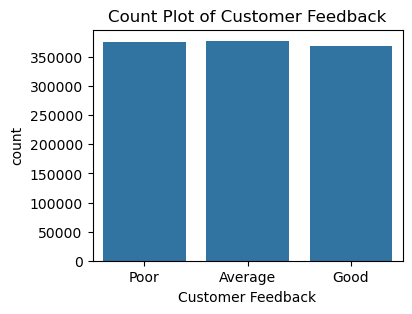

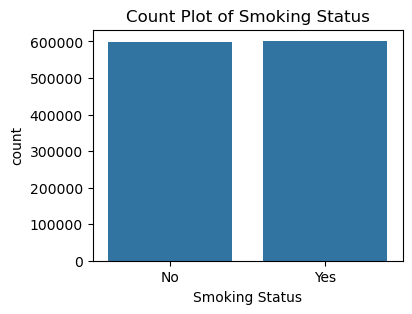

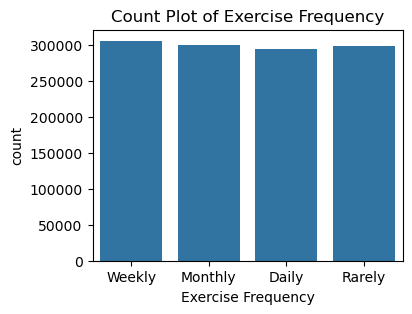

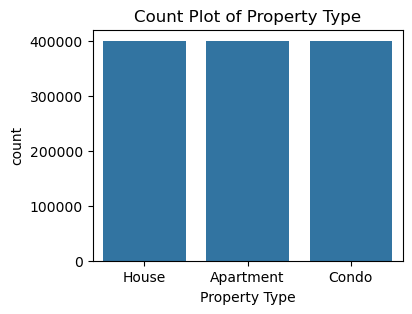

In [19]:
for col in cat_cols:
    plt.figure(figsize=(4, 3))
    sns.countplot(x=col, data=train)
    plt.title(f'Count Plot of {col}')
    plt.show()

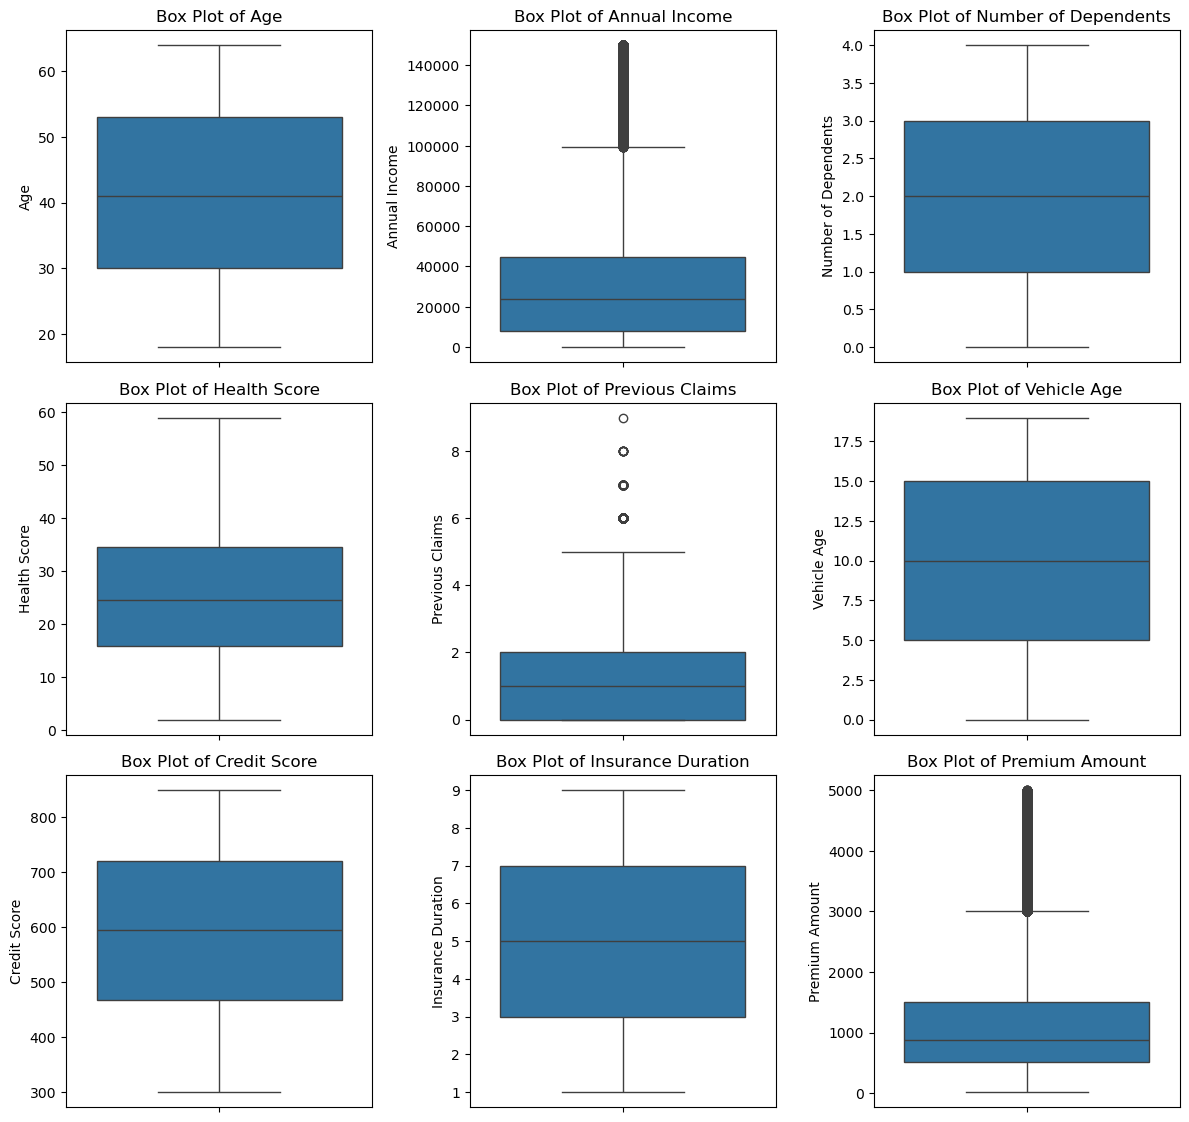

In [20]:
plt.figure(figsize=(12,15))
for i, col in enumerate(num_cols):
    plt.subplot(4,3, i+1)
    sns.boxplot(y=train[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


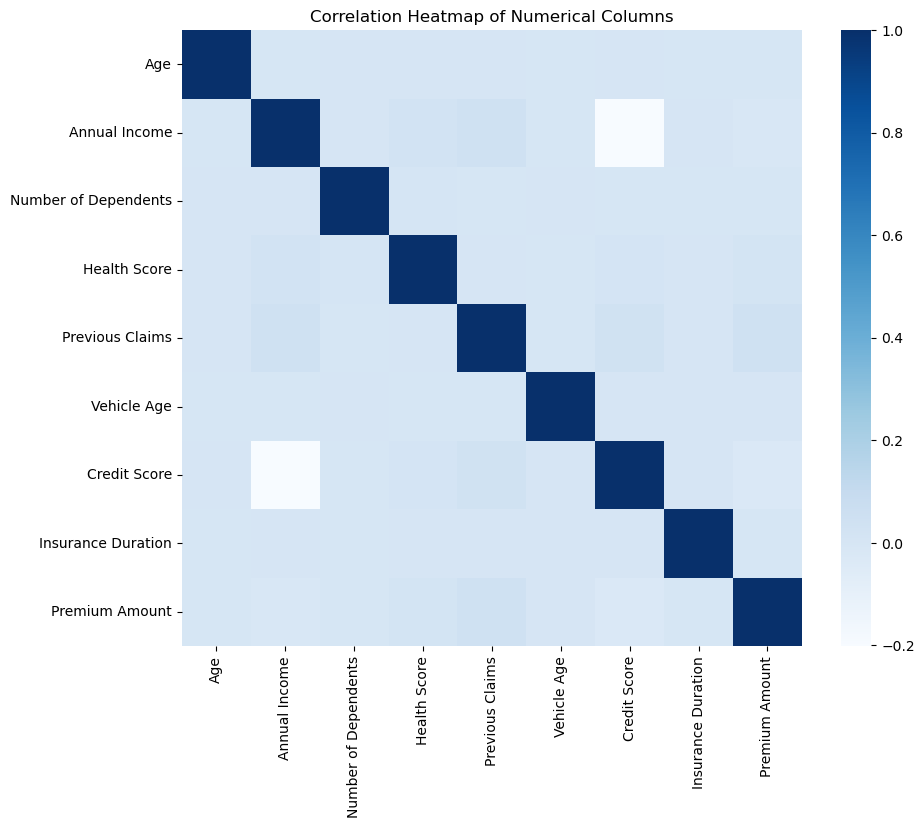

In [21]:
corr_matrix = train[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap = 'Blues')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

In [12]:
corr = train[num_cols].corr()['Premium Amount'].sort_values(ascending = False)
pd.DataFrame(corr).style.background_gradient(cmap='Blues')

,Premium Amount
Premium Amount,1.000000
Previous Claims,0.046874
Health Score,0.014704
Vehicle Age,0.000391
Insurance Duration,-0.000028
Number of Dependents,-0.000976
Age,-0.002430
Annual Income,-0.012390
Credit Score,-0.026014


# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 4. Preprocess</b></div>

In [6]:
for df in [train, test]:
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Year'] = df['Policy Start Date'].dt.year
    df = df.drop(columns = 'Policy Start Date', inplace = True)

print("New columns created: Day, Month, Year")

New columns created: Day, Month, Year


In [7]:
encoder = ce.TargetEncoder()

for feature in cat_cols:
    train[feature] = encoder.fit_transform(train[feature], train['Premium Amount'])
    test[feature] = encoder.transform(test[feature])

print("Categorical columns transformed with target encoder in train and test data: ")
cat_cols

Categorical columns transformed with target encoder in train and test data: 


['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type']

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 5. Days, Months & Years</b></div>

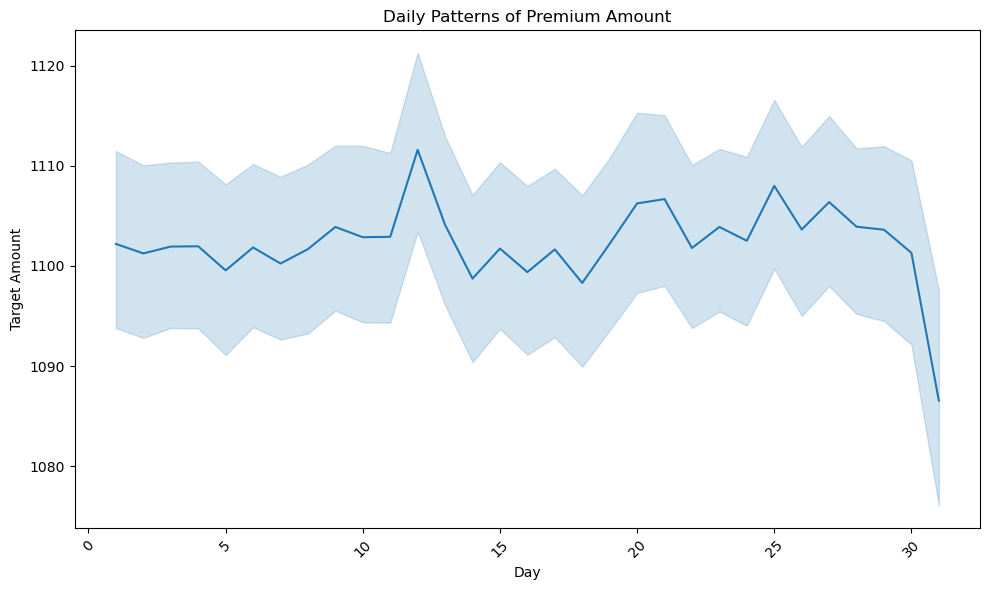

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Day', y='Premium Amount', data=train)
plt.xlabel('Day')
plt.ylabel('Target Amount')
plt.title('Daily Patterns of Premium Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


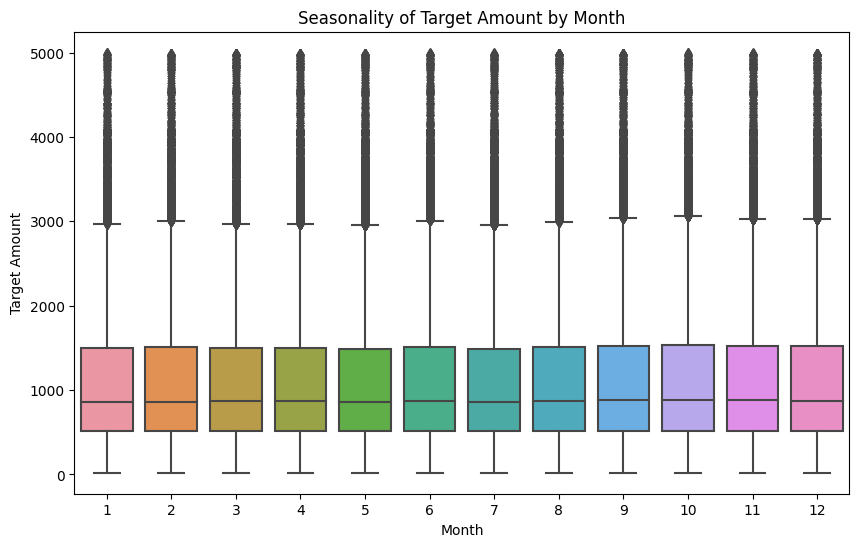

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Premium Amount', data=train)
plt.xlabel('Month')
plt.ylabel('Target Amount')
plt.title('Seasonality of Target Amount by Month')
plt.show()


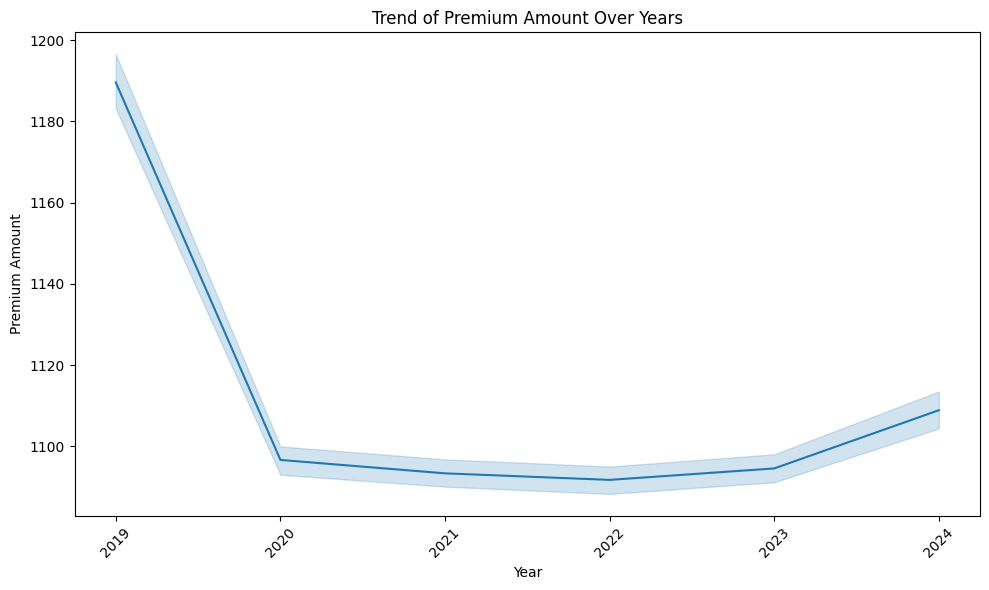

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Premium Amount', data=train)
plt.xlabel('Year')
plt.ylabel('Premium Amount')
plt.title('Trend of Premium Amount Over Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 6. Scoring</b></div>

In [8]:
# I have set a floor value of 20 in line with training data

def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 20)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

RMSLE = make_scorer(rmsle, greater_is_better=False)

print('Submissions are evaluated based on Root Mean Squared Logarithmic Error (RMSLE)')

Submissions are evaluated based on Root Mean Squared Logarithmic Error (RMSLE)


In [9]:
def cross_val_score_log(model, X, y, n_splits=5, random_state=42):
    
    """"
    Perform cross-validation and return scores using log-transformed y.
    """

    kf = KFold(n_splits = 5, shuffle=True, random_state=random_state)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        # Calculate the score directly in the logarithmic scale
        score = np.sqrt(mean_squared_error(y_test, preds))
        scores.append(score)

    mean_score = np.mean(scores)
    return mean_score

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 7. Feature Selection</b></div>

In [10]:
y = train['Premium Amount']
y_log = np.log1p(y)
X = train.drop(columns = ['Premium Amount'])

In [11]:
# Initialize the model
model = xgb.XGBRegressor(random_state=37, 
                         tree_method = 'hist', 
                         device = 'cuda', 
                         n_jobs = -1)

# Calculate the CV score with all features
cv_score = -cross_val_score(model, X, y, cv=5, scoring = RMSLE).mean()
print(f'CV score with all features: {cv_score}')

# Store the results in a list
results = []

# Loop through each feature and calculate the CV score without that feature
for feature in X.columns:
    X_temp = X.drop(feature, axis=1)
    cv_score_temp = -cross_val_score(model, X_temp, y, cv=5, scoring = RMSLE).mean()
    print(f'CV score without {feature}: {cv_score_temp}')
    results.append((feature, cv_score_temp))

# Sort the results in ascending order of CV scores
results.sort(key=lambda x: x[1])

# Store features whose removal results in a lower CV score
lower_cv_features = [feature for feature, score in results if score < cv_score]

# Print the sorted results and the features with lower CV scores
print("")
print("Features whose removal results in a lower CV score:")
print("")
for feature, score in results:
    if score < cv_score:
        print(f'- {feature}')

CV score with all features: 1.1334663378106744
CV score without Age: 1.1333294977273192
CV score without Gender: 1.133452702075353
CV score without Annual Income: 1.166477908104332
CV score without Marital Status: 1.134632078556793
CV score without Number of Dependents: 1.1335548464458085
CV score without Education Level: 1.1332928838702268
CV score without Occupation: 1.1333033157766104
CV score without Health Score: 1.1451839203013303
CV score without Location: 1.1333837628304457
CV score without Policy Type: 1.1333101001000094
CV score without Previous Claims: 1.1496109034644209
CV score without Vehicle Age: 1.1332794831563882
CV score without Credit Score: 1.159897916657513
CV score without Insurance Duration: 1.133273240583755
CV score without Customer Feedback: 1.1395750875456025
CV score without Smoking Status: 1.1332738450406197
CV score without Exercise Frequency: 1.133466805135487
CV score without Property Type: 1.1334848200986904
CV score without Day: 1.1330785034392998
CV s

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 8. Base Models</b></div>

In [12]:
X_fewer = X.drop(columns = lower_cv_features)

In [13]:
params1 = {
    'num_leaves': 71,
    'learning_rate': 0.05412467152424433,
    'n_estimators': 595,
    'max_depth': 12,
    'min_data_in_leaf': 97,
    'bagging_fraction': 0.5200288825838669,
    'feature_fraction': 0.9881738491942492,
    'verbose': -1, 
    'n_jobs': -1, 
    'device': 'gpu'
}

model1 = lgb.LGBMRegressor(**params1)

In [14]:
print(- cross_val_score(model1, X, y, cv = 5, scoring = RMSLE).mean())
print('LightBoost cross validation score with all features')
print("")
print(- cross_val_score(model1, X_fewer, y, cv = 5, scoring = RMSLE).mean())
print('Lightboost cross validation score with fewer features')
print("")
print(cross_val_score_log(model1, X, y))
print('LightBoost y_log cross validation score with all features')
print("")
print(cross_val_score_log(model1, X_fewer, y))
print('Lightboost y_log cross validation score with fewer features')

1.1305198632943882
LightBoost cross validation score with all features

1.1302439231581005
Lightboost cross validation score with fewer features

1.0457654845533262
LightBoost y_log cross validation score with all features

1.0457207914599516
Lightboost y_log cross validation score with fewer features


In [15]:
params2 = {
    'n_estimators': 221, 
    'learning_rate': 0.028812123231198472,
    'max_depth': 8,
    'min_child_weight': 10,
    'subsample': 0.7943663761611918,
    'colsample_bytree': 0.827901646829519,
    'tree_method': 'hist', 
    'device': 'cuda', 
    'n_jobs': -1
}
    
model2 = xgb.XGBRegressor(**params2)

In [16]:
print(- cross_val_score(model2, X, y, cv = 5, scoring = RMSLE).mean())
print('XGBoost cross validation score with all features')
print("")
print(- cross_val_score(model2, X_fewer, y, cv = 5, scoring = RMSLE).mean())
print('XGBoost cross validation score with fewer features')
print("")
print(cross_val_score_log(model2, X, y))
print('XGBoost y_log cross validation score with all features')
print("")
print(cross_val_score_log(model2, X_fewer, y))
print('XGBoost y_log cross validation score with fewer features')

1.1330531126585002
XGBoost cross validation score with all features

1.1328978269011614
XGBoost cross validation score with fewer features

1.0456266316531408
XGBoost y_log cross validation score with all features

1.0454692708046904
XGBoost y_log cross validation score with fewer features


# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 9. Out-of-Fold Predictions</b></div>

Here we create a dataset containing out-of-fold (OOF) predictions from our top two models, which use selected features and use y_log as the target.

In [17]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store OOF predictions
oof_preds_model1 = np.zeros(len(X_fewer))
oof_preds_model2 = np.zeros(len(X_fewer))
oof_true = np.zeros(len(X))

# Loop through each fold
for train_idx, val_idx in kf.split(X_fewer):
    X_train, X_val = X_fewer.iloc[train_idx], X_fewer.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Clone and fit model1 on log-transformed target
    model1_clone = clone(model1)
    model1_clone.fit(X_train, np.log1p(y_train))
    oof_preds_model1[val_idx] = model1_clone.predict(X_val)
    
    # Clone and fit model2 on log-transformed target
    model2_clone = clone(model2)
    model2_clone.fit(X_train, np.log1p(y_train))
    oof_preds_model2[val_idx] = model2_clone.predict(X_val)
    
    # Store true values
    oof_true[val_idx] = np.log1p(y_val)

In [18]:
# Combine OOF predictions into a new dataset
stacking_X = np.column_stack((oof_preds_model1, oof_preds_model2))
stacking_y = oof_true

column_names_X = ["lightboost_preds", "xgboost_preds"] 
column_name_y = "y_log"  
stacking_X_df = pd.DataFrame(stacking_X, columns=column_names_X)
stacking_y_series = pd.Series(stacking_y, name=column_name_y)
oof_preds = pd.concat([stacking_X_df, stacking_y_series], axis=1)
oof_preds.to_csv('oof_preds.csv', index=False)

print("Data saved to oof_preds.csv")


Data saved to oof_preds.csv


In [19]:
oof_preds.head()

,lightboost_preds,xgboost_preds,y_log
0,6.873753,6.881359,7.962067
1,6.558522,6.569643,7.302496
2,6.708638,6.685025,6.342121
3,6.675436,6.674551,6.641182
4,6.620637,6.653104,7.612337


# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 10. Stacking Example</b></div>

In [20]:
# Define the model

params3 =  {
    'learning_rate': 0.09305246782295545, 
    'max_iter': 437, 
    'max_leaf_nodes': 125, 
    'max_depth': 3, 
    'min_samples_leaf': 1, 
    'l2_regularization': 0.019857090207145767,
}

stacking_model = HistGradientBoostingRegressor(**params3)

In [21]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state = 37)

# Array to store stacking model predictions
stacking_preds = np.zeros(len(stacking_X))

for train_idx, val_idx in kf.split(stacking_X):
    X_train, X_val = stacking_X[train_idx], stacking_X[val_idx]
    y_train, y_val = stacking_y[train_idx], stacking_y[val_idx]
    
    # Fit the stacking model
    stacking_model.fit(X_train, y_train)
    
    # Predict on validation set
    stacking_preds[val_idx] = stacking_model.predict(X_val)

    # Fit the stacking model
    stacking_model.fit(X_train, y_train)
    
    # Predict on validation set
    stacking_preds[val_idx] = stacking_model.predict(X_val)

# Calculate RMSLE for the stacking model
score = np.sqrt(mean_squared_error(stacking_y, stacking_preds))
print(f'Stacking Model OOF RMSLE: {score}')

Stacking Model OOF RMSLE: 1.0451093960067157


# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 11. Blending Example</b></div>

In [22]:
from itertools import product

# Define a finer range of weights to explore
weight_range = np.arange(0, 1.05, 0.05)

# Generate all possible combinations of weights that sum to 1
weight_combinations = [weights for weights in product(weight_range, repeat=2) if np.isclose(sum(weights), 1)]

# Function to calculate blended predictions and RMSLE
def calculate_blended_score(weights):
    blended_preds = (
        weights[0] * oof_preds['lightboost_preds'] +
        weights[1] * oof_preds['xgboost_preds']
    )
    score = np.sqrt(mean_squared_error(stacking_y, blended_preds))
    return score

# Iterate over different weight combinations and calculate scores
best_score = float('inf')
best_weights = None

for weights in weight_combinations:
    rounded_weights = tuple(round(w, 2) for w in weights)
    score = calculate_blended_score(weights)
    if score < best_score:
        best_score = score
        best_weights = rounded_weights
    print(f'Weights: {rounded_weights}, Blended Model OOF RMSLE: {score}')

print()
print(f'Best Weights: {best_weights}, Best Blended Model OOF RMSLE: {best_score}')


Weights: (0.0, 1.0), Blended Model OOF RMSLE: 1.0454694954497958
Weights: (0.05, 0.95), Blended Model OOF RMSLE: 1.045402219907129
Weights: (0.1, 0.9), Blended Model OOF RMSLE: 1.0453433847567253
Weights: (0.15, 0.85), Blended Model OOF RMSLE: 1.0452929914238067
Weights: (0.2, 0.8), Blended Model OOF RMSLE: 1.045251041129356
Weights: (0.25, 0.75), Blended Model OOF RMSLE: 1.0452175348899708
Weights: (0.3, 0.7), Blended Model OOF RMSLE: 1.045192473517735
Weights: (0.35, 0.65), Blended Model OOF RMSLE: 1.045175857620125
Weights: (0.4, 0.6), Blended Model OOF RMSLE: 1.0451676875999367
Weights: (0.45, 0.55), Blended Model OOF RMSLE: 1.045167963655231
Weights: (0.5, 0.5), Blended Model OOF RMSLE: 1.0451766857793165
Weights: (0.55, 0.45), Blended Model OOF RMSLE: 1.0451938537607457
Weights: (0.6, 0.4), Blended Model OOF RMSLE: 1.0452194671833444
Weights: (0.65, 0.35), Blended Model OOF RMSLE: 1.0452535254262565
Weights: (0.7, 0.3), Blended Model OOF RMSLE: 1.0452960276640257
Weights: (0.75, 

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 12. Prediction</b></div>

The simple stacking example gives a slightly better score than blending so we will use it here.

In [23]:
test_fewer = test.drop(columns = lower_cv_features)
print("Predict using the following test columns to match the best model training:")
[ val for val in test_fewer.columns]

Predict using the following test columns to match the best model training:


['Annual Income',
 'Marital Status',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Credit Score',
 'Customer Feedback',
 'Exercise Frequency',
 'Property Type',
 'Year']

In [24]:
model1preds = model1.fit(X_fewer, y_log).predict(test_fewer)
model2preds = model2.fit(X_fewer, y_log).predict(test_fewer)
test_X = np.column_stack((model1preds, model2preds))
log_preds = stacking_model.fit(stacking_X, stacking_y).predict(test_X)
preds = np.expm1(log_preds)

# <div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 13. Submission</b></div>

In [26]:
submission['Premium Amount'] = preds
submission.to_csv('reference.csv')
print("Submission created and saved successfully!")

Submission created and saved successfully!
